In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
#from celluloid import Camera
import matplotlib.cm as cm
plt.rcParams.update({'font.size': 14})
import os, sys
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
    
def calcvelocity(rrange,sigma,vdiff,A,vmin):         #Calculate the introduced velocity profile
    sigmaterm = sigma**2
    distances = np.linspace(0,rrange,int(nx/2+1))
    I = A*np.exp(-distances**2/sigmaterm)
    return distances, vactive*vdiff*np.exp(-I/A)+vmin, I

In [2]:
name = 'Focker-Planck'

amplitude = 1                    #Amplitude, always 1
vmin = 0                         #Min velocity
vmax = 1                         #Max velocity
pxtomum=0.0533e-6               #px to µm [µm/px]
sigma = 70*pxtomum               #Sigma for the Gaussian intensity profile [px]
D_0 = 3.85e-14#*1e12              #measured diffusion coefficient D_0 = kB*T/(6*np.pi*eta*radius)
boundaryradius = pxtomum * 200   #Size of the arena
vactive = 6e-6                      #Active velocity

vdiff = vmax-vmin
nx = 101
nt = 50
tauR = 1
delta_x = 2*boundaryradius/nx
savefolder = '.'

dt = 0.05
videosize = 800        #800, 521, 256, 128
binning = 1
frametransfer = False
flashtime = 0.01
verticalshift = 1.9176e-6
dtprogram = 10e-3
dtcamtoPC = 1e-3
dtPCtoADwin = 1e-3
delayincrease = 4

length = 10
delaywave = np.zeros(length)
for p in range(length):
    start_time = time.time() 
    frames = 1 + delayincrease*p

    check = True
    dtframetransfer = videosize/binning * verticalshift
    dtreadout = (1032/27e6+verticalshift)*videosize/binning
    dtexphalf = flashtime/2
    dttest = flashtime + dtframetransfer + dtreadout
    dtcycle = dt + dtframetransfer
    dttotal = dtexphalf + dtframetransfer + dtreadout + dtcamtoPC + dtprogram + dtPCtoADwin + (frames-1)*dtcycle
    if dttest > dt: 
        check = False
        dtnew = dttest
        dtcycle = dttest    

    #if check == True: print('dt = ',round(dt*1000,1),'ms - delay = ',round(dttotal*1000,1),'ms - cycle time = ',round(dtcycle*1000,1),'ms')   
    #else: print('dt = ',round(dtnew*1000,1),'ms - delay = ',round(dttotal*1000,1),'ms - cycle time = ',round(dtcycle*1000,1),'ms')   
    delaywave[p] = dttotal

tauwave = [0.2,0.4,0.65,0.85,1.05]
taulength = int(len(tauwave))
howlong = taulength*length
alldata = np.zeros((howlong,5))
count = 0
for i in range(howlong):
    alldata[i,0] = i
    alldata[i,1] = tauwave[count]
    alldata[i,2] = 1 + delayincrease * int(i % length) 
    alldata[i,3] = delaywave[int(i % length)]
    if (i+1) % length == 0: count += 1
    #print(str(i)+'/'+str(howlong)+' - tau = '+str(alldata[i,1])+' - dt = '+str(alldata[i,2]))

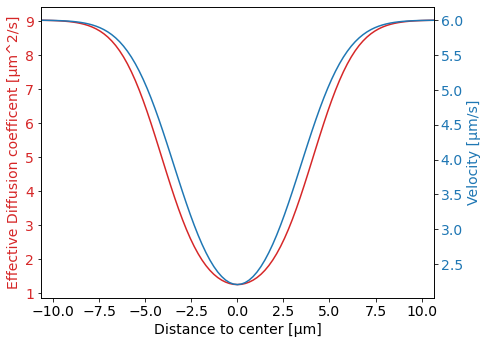

In [3]:
xarray1, varray1, Iarray1 = calcvelocity(boundaryradius,sigma,vdiff,amplitude,vmin)
xarray = np.linspace(-boundaryradius,boundaryradius,nx)
varray = np.zeros(nx)
for i in range(int(nx/2+1)):
    varray[int(nx/2)+i] = varray1[i]
    varray[int(nx/2)-i] = varray1[i]
Darray = D_0 + varray**2*tauR/4

fig, ax = plt.subplots(figsize=(7,5)) 
ax1 = plt.subplot(1,1,1)
color1 = 'tab:red'
ax1.plot(xarray*1e6,Darray*1e12,color=color1)
ax1.set_xlabel('Distance to center [µm]')
ax1.set_ylabel('Effective Diffusion coefficent [µm^2/s]',color=color1) 
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim([-boundaryradius*1e6,boundaryradius*1e6])
#ax1.set_ylim([0,9.5])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color2 = 'tab:blue'
ax2.plot(xarray*1e6,varray*1e6,color=color2)
ax2.set_ylabel('Velocity [µm/s]',color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
#ax2.set_ylim([0,6.5])

plt.tight_layout() 
plt.savefig('Diffusion coefficent profiles.pdf', format='pdf')
plt.savefig('Diffusion coefficent profiles.svg', format='svg')
plt.show()

In [4]:
saveall = np.zeros((nx,howlong,3))
check = True; count = int(nx/2)
calctime = 0
for p in range(howlong):
    start_time = time.time() 
    totaltime = alldata[p,3]
    frames = alldata[p,2]
    tauR = alldata[p,1]
    Darray = D_0 + varray**2*tauR/4
    delta_t = totaltime/nt
    
    G = delta_t/delta_x**2
    M = np.zeros((nx,nx))
    for i in range(1,nx):
        M[i,i] = 1+G*(3*Darray[i]-Darray[i-1])
        M[i,i-1] = -G*Darray[i-1] 
        M[i-1,i] = G*(Darray[i-1]-2*Darray[i])
    M[0,0] = M[-1,-1] = 1   #Neumann boundary condition  c[0,:] = c[-1,:] = 0
    M[0,1] = M[-1,-2] = -1

    endpointarray = np.zeros((nx,nx)) 
    for k in range(nx):
        unew = np.zeros((nx,nt))        #array to save the density distributions
        unew[k,0] = 1/delta_x
        for i in range(1,nt):
            b = unew[:,i-1]
            b[0] = 0
            b[-1] = 0#b[1]
            csingle = np.linalg.solve(M,b)
            unew[:,i] = csingle/sum(abs(csingle)*delta_x)
        endpointarray[:,k] = unew[:,-1]
    x = xarray[:]

    startpointarray = np.zeros((nx,nx))
    for k in range(nx):
        for i in range(nx): startpointarray[i,k] = endpointarray[k,i]      
    for k in range(nx): startpointarray[1:-1,k] /= sum(startpointarray[1:-1,k])*delta_x    
    areaend = np.zeros(nx)
    areastart = np.zeros(nx)
    for i in range(nx):
        areastart[i] = np.sum(startpointarray[1:-1,i])*delta_x
        areaend[i] = np.sum(endpointarray[:,i])*delta_x
    #------------------------------------------------------    
    string_temp = savefolder + '/PlotDensityprofiles-pdf/'
    if not os.path.exists(string_temp): os.makedirs(string_temp)
    string_temp2 = savefolder + '/PlotDensityprofiles-svg/'
    if not os.path.exists(string_temp2): os.makedirs(string_temp2)
    colorwave = cm.plasma(np.linspace(0, 1, nx))
    fig, ax = plt.subplots(figsize=(15,10)) 
    fig.suptitle('Delay = '+str(int(totaltime*1000))+' ms - frames = '+str(frames))
    ax1 = plt.subplot(2,2,1)
    for i in range(nx):
        if i % int(nx/10) == 0:
            ax1.plot(x,endpointarray[:,i],color=colorwave[i])
            ax1.axvline(x=x[i],linewidth=0.5, color = colorwave[i],linestyle='--')
    ax1.set_xlabel('Distance to center [µm]')
    ax1.set_ylabel('Density') 
    ax1.set_title('Distribution of ending points')
    #ax1.set_xlim([-boundaryradius,boundaryradius])

    ax2 = plt.subplot(2,2,2)
    for i in range(nx):
        if i % int(nx/10) == 0:
            ax2.plot(x,startpointarray[:,i],color=colorwave[i])
            ax2.axvline(x=x[i],linewidth=0.5, color = colorwave[i],linestyle='--')
    ax2.set_xlabel('Distance to center [µm]')
    ax2.set_ylabel('Density') 
    ax2.set_title('Distribution of starting points')

    ax3 = plt.subplot(2,2,3)
    ax3.plot(x,areaend)
    ax3.set_ylim([0,1.2])
    ax3.set_xlabel('Distance to center [µm]')
    ax3.set_ylabel('Area under every ending point distribution') 
    ax3.set_title('Area under each distribution of ending points')

    ax4 = plt.subplot(2,2,4)
    ax4.plot(x,areastart)
    ax4.set_ylim([0,1.2])
    ax4.set_xlabel('Distance to center [µm]')
    ax4.set_ylabel('Area under every starting point distribution') 
    ax4.set_title('Area under each distribution of starting points')

    plt.tight_layout() 
    plt.savefig(string_temp+'Density profiles - delay '+str(int(totaltime*1000))+' ms.pdf', format='pdf')
    plt.savefig(string_temp2+'Density profiles - delay '+str(int(totaltime*1000))+' ms.svg', format='svg')
    plt.close(fig)#show()  
    #------------------------------------------------------  
    newvelocity = np.zeros(nx)
    for k in range(nx): newvelocity[k] = np.sum(varray[1:-1] * startpointarray[1:-1,k])*delta_x

    string_temp = savefolder + '/PlotVelocityprofiles-pdf/'
    if not os.path.exists(string_temp): os.makedirs(string_temp)
    string_temp2 = savefolder + '/PlotVelocityprofiles-svg/'
    if not os.path.exists(string_temp2): os.makedirs(string_temp2)
    fig, ax = plt.subplots(figsize=(7,5)) 
    plt.plot(x*1e6,newvelocity*1e6,label='v resulting')
    plt.plot(xarray*1e6,varray*1e6,label='v input')
    plt.title('Delay = '+str(int(totaltime*1000))+' ms - frames = '+str(frames))
    plt.xlabel('Distance to center [µm]')
    plt.ylabel('Velocity [µm/s]') 
    plt.legend()
    plt.tight_layout() 
    plt.savefig(string_temp+'v profiles - delay '+str(int(totaltime*1000))+' ms.pdf', format='pdf')
    plt.savefig(string_temp2+'v profiles - delay '+str(int(totaltime*1000))+' ms.svg', format='svg')
    plt.close(fig)#show() 
    #------------------------------------------------------ 
    ntnew = 1000
    dttotalnew = 50
    delta_tnew = dttotalnew/ntnew

    Darraynew = D_0 + newvelocity**2*tauR/4
    G = delta_tnew/delta_x**2
    M = np.zeros((nx,nx))
    for i in range(1,nx):
        M[i,i] = 1+G*(3*Darraynew[i]-Darraynew[i-1])
        M[i,i-1] = -G*Darraynew[i-1] 
        M[i-1,i] = G*(Darraynew[i-1]-2*Darraynew[i])
    M[0,0] = M[-1,-1] = 1   #Neumann boundary condition  c[0,:] = c[-1,:] = 0
    M[0,1] = M[-1,-2] = -1

    unew = np.zeros((nx,ntnew))        #array to save the density distributions
    unew[:,0] = 1/newvelocity
    unew[:,0] /= sum(unew[:,0])*delta_x
    for i in range(1,ntnew):
        b = unew[:,i-1].copy()
        b[0] = 0
        b[-1] = 0#b[1]
        csingle = np.linalg.solve(M,b)
        unew[:,i] = csingle/sum(abs(csingle)*delta_x)
    #------------------------------------------------------ 
    M = np.zeros((nx,nx))
    for i in range(1,nx):
        M[i,i] = 1+G*(3*Darray[i]-Darray[i-1])
        M[i,i-1] = -G*Darray[i-1] 
        M[i-1,i] = G*(Darray[i-1]-2*Darray[i])
    M[0,0] = M[-1,-1] = 1   #Neumann boundary condition  c[0,:] = c[-1,:] = 0
    M[0,1] = M[-1,-2] = -1

    unew2 = np.zeros((nx,ntnew))        #array to save the density distributions
    unew2[:,0] = 1/varray
    unew2[:,0] /= sum(unew2[:,0])*delta_x
    for i in range(1,ntnew):
        b = unew2[:,i-1].copy()
        b[0] = 0
        b[-1] = 0#b[1]
        csingle = np.linalg.solve(M,b)
        unew2[:,i] = csingle/sum(abs(csingle)*delta_x)
    c = unew

    string_temp = savefolder + '/PlotDensitycompares-pdf/'
    if not os.path.exists(string_temp): os.makedirs(string_temp)
    string_temp2 = savefolder + '/PlotDensitycompares-svg/'
    if not os.path.exists(string_temp2): os.makedirs(string_temp2)
    fig=plt.figure(1, figsize = (7,5) )
    ax1 = plt.subplot(1,1,1)
    plt.plot(x*1e6,c[:,-1]*1e-6,label='include D_eff')
    plt.plot(x*1e6,unew2[:,-1]*1e-6,label = 'just D = 1/v')
    #plt.ylim([0,0.4])
    ax1.set_xlabel('Distance to center [µm]')
    ax1.set_ylabel('Density') 
    plt.legend()
    plt.tight_layout() 
    plt.savefig(string_temp+'Density profiles compared - delay '+str(int(totaltime*1000))+' ms.pdf', format='pdf')
    plt.savefig(string_temp2+'Density profiles compared - delay '+str(int(totaltime*1000))+' ms.svg', format='svg')
    plt.close(fig)#show()
    
    saveall[:,p,0] = x
    saveall[:,p,1] = newvelocity
    saveall[:,p,2] = c[:,-1]
    
    while check == True:
        if x[count]*1e6 >= 1:
            endhere = count
            check = False
        else: count += 1  
    alldata[p,4] = np.sum(c[int(nx/2):endhere,-1])*delta_x
    
    print('tau_R = '+str(tauR)+' - delay = '+str(frames)+' - density = '+str(round(alldata[p,4],3)))
    print("--- %s seconds ---" % round((time.time() - start_time),2))
    calctime += round((time.time() - start_time),2)

<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.2 - delay = 1.0 - density = 0.235
--- 2.71 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.2 - delay = 5.0 - density = 0.241
--- 2.75 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.2 - delay = 9.0 - density = 0.247
--- 2.72 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.2 - delay = 13.0 - density = 0.251
--- 2.79 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.2 - delay = 17.0 - density = 0.254
--- 2.98 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.2 - delay = 21.0 - density = 0.255
--- 2.67 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.2 - delay = 25.0 - density = 0.255
--- 2.73 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.2 - delay = 29.0 - density = 0.253
--- 2.76 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.2 - delay = 33.0 - density = 0.251
--- 2.85 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.2 - delay = 37.0 - density = 0.247
--- 2.69 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.4 - delay = 1.0 - density = 0.246
--- 2.79 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.4 - delay = 5.0 - density = 0.258
--- 2.86 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.4 - delay = 9.0 - density = 0.266
--- 2.76 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.4 - delay = 13.0 - density = 0.267
--- 2.76 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.4 - delay = 17.0 - density = 0.263
--- 2.87 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.4 - delay = 21.0 - density = 0.255
--- 2.68 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.4 - delay = 25.0 - density = 0.244
--- 2.7 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.4 - delay = 29.0 - density = 0.233
--- 2.71 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.4 - delay = 33.0 - density = 0.221
--- 3.04 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.4 - delay = 37.0 - density = 0.209
--- 2.89 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.65 - delay = 1.0 - density = 0.251
--- 2.84 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.65 - delay = 5.0 - density = 0.268
--- 2.66 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.65 - delay = 9.0 - density = 0.27
--- 2.71 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.65 - delay = 13.0 - density = 0.259
--- 2.69 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.65 - delay = 17.0 - density = 0.241
--- 3.05 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.65 - delay = 21.0 - density = 0.222
--- 2.69 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.65 - delay = 25.0 - density = 0.203
--- 2.67 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.65 - delay = 29.0 - density = 0.186
--- 2.69 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.65 - delay = 33.0 - density = 0.172
--- 2.99 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.65 - delay = 37.0 - density = 0.159
--- 2.67 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.85 - delay = 1.0 - density = 0.254
--- 2.7 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.85 - delay = 5.0 - density = 0.273
--- 2.96 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.85 - delay = 9.0 - density = 0.266
--- 2.73 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.85 - delay = 13.0 - density = 0.243
--- 2.68 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.85 - delay = 17.0 - density = 0.217
--- 2.67 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.85 - delay = 21.0 - density = 0.194
--- 2.67 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.85 - delay = 25.0 - density = 0.174
--- 2.66 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.85 - delay = 29.0 - density = 0.158
--- 2.67 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.85 - delay = 33.0 - density = 0.145
--- 3.0 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 0.85 - delay = 37.0 - density = 0.134
--- 2.66 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 1.05 - delay = 1.0 - density = 0.257
--- 2.77 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 1.05 - delay = 5.0 - density = 0.274
--- 2.75 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 1.05 - delay = 9.0 - density = 0.256
--- 2.76 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 1.05 - delay = 13.0 - density = 0.224
--- 2.68 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 1.05 - delay = 17.0 - density = 0.194
--- 2.78 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 1.05 - delay = 21.0 - density = 0.171
--- 2.72 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 1.05 - delay = 25.0 - density = 0.152
--- 2.7 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 1.05 - delay = 29.0 - density = 0.138
--- 2.74 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 1.05 - delay = 33.0 - density = 0.126
--- 3.11 seconds ---


<ipython-input-4-91306806cf52>:30: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


tau_R = 1.05 - delay = 37.0 - density = 0.117
--- 2.67 seconds ---


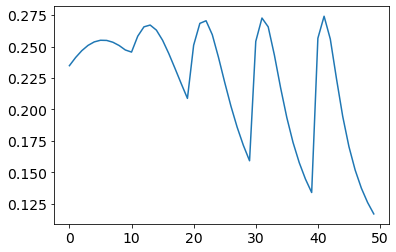

In [6]:
plt.plot(alldata[:,4])

In [9]:
def plotit(xin,yin,y2in,vin,start,end,xname,yname,vname,titlename,savename,maxor,border,dots,both,background,xaxislog):    
    colormap = 'viridis'   #viridis
    value = 0.05
    xdots = xin[start:end]#np.sqrt(2*meandrot)#
    ydots = yin[start:end]
    y2dots = y2in[start:end]
    vdots = vin[start:end]
    count = 0; x = []; x.append(xdots[0])
    count2 = 0; y = []; y.append(ydots[0]); y2 = []; y2.append(y2dots[0])
    for i in range(len(xdots)):
        if xdots[i] > x[count]:
            x.append(xdots[i])
            count +=1
        if ydots[i] > y[count2]:
            y.append(ydots[i])
            y2.append(y2dots[i])
            count2 +=1
    xlength = len(x); ylength = len(y)
    z = np.zeros((ylength,xlength)); count = 0
    for i in range(xlength):
        for j in range(ylength):
            if count < num:
                z[j,i] = vdots[count]
                count += 1
            if count > num: z[j,i] = np.nan
    if dots == True: 
        if both == True: fig, ax1 = plt.subplots(figsize=(7,5.5))
        else: fig, ax1 = plt.subplots(figsize=(7,5.5))
    else: fig, ax1 = plt.subplots(figsize=(7,5.5))
    ax = plt.subplot(111)
    plt.title(titlename)
    if background == True:
        if both == True: im = ax.contourf(x,y,z,cmap=colormap,alpha=0.4)
        else: im = ax.contourf(x,y,z,cmap=colormap,alpha=0.6)
        im = ax.contour(x,y,z,cmap='gray')
    ax.set_xlabel(xname)#
    ax.set_ylabel(yname)
    ax.tick_params(axis='y')
    if border == True:
        ax.set_ylim([(1-value)*min(y),(1+value)*max(y)])
        ax.set_xlim([(1-value)*min(x),(1+value)*max(x)])
    if dots == True:
        im = ax.scatter(xdots,ydots,c=vdots,linewidths=5,marker='o',cmap=colormap)
        if border == False:
            ax.set_ylim([min(ydots),max(ydots)])
            ax.set_xlim([min(xdots),max(xdots)])
        else:
            ax.set_ylim([(1-value)*min(y2ots),(1+value)*max(ydots)])
            ax.set_xlim([(1-value)*min(xdots),(1+value)*max(xdots)])
    if both == True:
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        im2 = ax2.contourf(x,y2,z,cmap=colormap,alpha=0.4)
        im2 = ax2.contour(x,y2,z,cmap='gray')
        ax2.set_ylabel('Delay N [frames]')  # we already handled the x-label with ax1
        ax2.tick_params(axis='y')
        if border == True:
            ax2.set_ylim([(1-value)*min(y2),(1+value)*max(y2)])
            ax2.set_xlim([(1-value)*min(x),(1+value)*max(x)])       
        pad1 = 1      
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes("right", size="5%", pad=1)
        plt.colorbar(im, cax=cax2)
    else: pad1 = 0.5        
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=pad1)
    plt.colorbar(im, cax=cax)
    plt.ylabel(vname)  
    if xaxislog == True: ax.set_xscale('log')
    line = np.linspace(min(xdots),max(xdots),1000)
    #ax.plot(line,line,'k--')
    plt.tight_layout()
    plt.savefig(savename+'.pdf', format='pdf')
    plt.savefig(savename+'.svg', format='svg')
    #for i in range(len(vdots)):
    #    if maxor == True:
    #        if vdots[i] == max(vdots[:]): print('delay = ',round(dataimportant[i,2],2),'s - noise = ',round(xdots[i],2),' - max',vname,'= ',round(min(vdots),2))
    #    else:
    #        if vdots[i] == min(vdots[:]): print('delay = ',round(dataimportant[i,2],2),'s - noise = ',round(xdots[i],2),' - min',vname,'= ',round(min(vdots),2))
    plt.show()

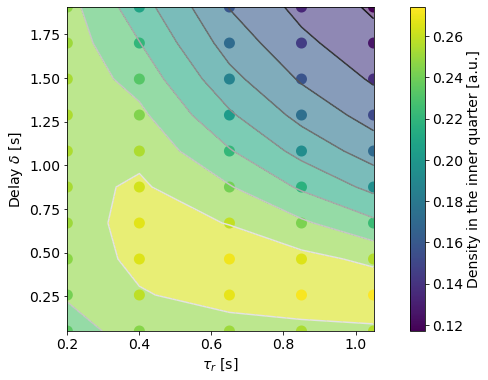

In [10]:
plotwave = np.zeros((howlong,3))
plotwave[:,0] = alldata[:,1]
plotwave[:,1] = alldata[:,3]#delaywave
plotwave[:,2] = alldata[:,4]
if plotwave[-1,0] < plotwave[0,0]: 
    plotwave = plotwave[plotwave[:,1].argsort(kind='mergesort')]
    plotwave = plotwave[plotwave[:,0].argsort(kind='mergesort')]
num = howlong
    
ix = plotwave[:,0]#allimportant[4,start:end]#np.sqrt(1/allimportant[6,:])#
idelayN = plotwave[:,1]
idelay = alldata[:,2]
ivin = plotwave[:,2]#test#
istart = 0
iend = howlong
ixname = str(r'$\tau_{r}$ [s] ')
iyname = str(r'Delay $\delta$ [s]')
ivname = str('Density in the inner quarter [a.u.]')
ititlename = str('')
isavename = str('Density theory')
imaxor = False
plotit(ix,idelayN,idelay,ivin,istart,iend,ixname,iyname,ivname,ititlename,isavename,imaxor,border = False,dots = True,both = False, background = True,xaxislog = False)   